In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

import tqdm

# Baseline model

1. Train set: Use data from 7am - 17pm in train set
2. Test set: To evaluate, only evaluate prediction from 9am - 17pm 
3. Impute missing for all data
4. Scale min max, fit train set
5. Train features to predict their futures by LSTM
6. Train features with response to predict response by Regression

In [137]:
def impute_missing(data):
  """
  data: DataFrame
  """
  
  features = data.columns
  for feature in features:
    data[feature] = data[feature].interpolate(method='nearest', limit_direction='both')
    data[feature] = data[feature].ffill()
    data[feature] = data[feature].bfill()
  
  return data


def scale_min_max(fit_data):
  """
  train_set, test_set: numpy array
  """
  minmax_scaler = MinMaxScaler().fit(fit_data)
  data_scaled = minmax_scaler.transform(fit_data)
  # val_set_scaled = minmax_scaler.transform(val_set)
  # test_set_scaled = minmax_scaler.transform(test_set)

  return data_scaled, minmax_scaler


def window_data(data, look_back_num):
  """
  data: numpy array
  """
  X_train = []
  y_train = []

  # # input X, each look_back_num points is corresponding to 1 y (y dim is 5)
  for i in range(look_back_num, data.shape[0]):
    X_train.append(data[i-look_back_num:i, :])
    y_train.append(data[i, :])

  X_train = np.array(X_train)
  y_train = np.array(y_train)

  X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], data.shape[1]))  # num obs * time sequence length * num features

  return X_train, y_train


# Modelling

def lstm_model(X_train, y_train, epochs, batch_size):
  regressor = Sequential()
  regressor.add(LSTM(units = 128, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))  # each input is time sequence length * num features
  regressor.add(LSTM(units = 64))
  regressor.add(Dropout(0.2))

  # output layer
  regressor.add(Dense(units=y_train.shape[1]))
  regressor.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
  # regressor.summary()
  history = regressor.fit(X_train, y_train, epochs = epochs, batch_size = batch_size, verbose=False)

  return regressor, history

def train_model(loc, look_back_num, epochs, batch_size):
  ## LSTM

  train_file = os.path.join(os.getcwd(), "data/avg_data_10min_wh/loc_{i}/fold_4/train.csv".format(i=loc))
  train_set = pd.read_csv(train_file, encoding='utf-8')

  features = ['WindSpeed(m/s)','Pressure(hpa)','Temperature(°C)','Humidity(%)','Sunlight(Lux)', 'Power(mW)']
  X_features = features[:-1]
  train_imputed = impute_missing(train_set[features])
  # print(np.sum(np.isnan(train_imputed)))
  train_scaled, minmax_scaler = scale_min_max(train_imputed[X_features])
  X_train, X_train_later = window_data(train_scaled, look_back_num)
  regressor, history = lstm_model(X_train, X_train_later, epochs, batch_size)

  ## Regression

  y_train = np.log(train_imputed[['Power(mW)']])
  lin_reg = LinearRegression(n_jobs=5)
  lin_reg.fit(train_scaled, y_train)

  return minmax_scaler, regressor, history, lin_reg

In [129]:
def lstm_predict(model, forecast_num, look_back_num, X_test):
  # Only apply for look_back_num = 12 and forecast_num = 48
  predictions = []
  
  i = 0
  complete_day = (len(X_test) + look_back_num) // (forecast_num + look_back_num)
  interval_left = (len(X_test) + look_back_num) % (forecast_num + look_back_num)
  if (interval_left == 0): 
    count = forecast_num
  else:
    count = interval_left
    
  while i < len(X_test) - count: 
    if i > forecast_num:
      i += look_back_num
      
    input = X_test[i].reshape(1, X_test.shape[1], X_test.shape[2])
    for _ in range(forecast_num):
      next_pred = model.predict(input, verbose=False)
      predictions.append(next_pred[0])
      input = np.append(input[:, 1:, :], [[next_pred[0]]], axis=1)
    i += forecast_num

  if (interval_left >= look_back_num):
    predictions = np.array(predictions)[:(complete_day * forecast_num) + interval_left - look_back_num]
  else:
    predictions = np.array(predictions)[:(complete_day * forecast_num)]

  return np.array(predictions)


def predict_power(loc, look_back_num, forecast_num, lstm_regressor, lin_reg, minmax_scaler):
  test_file = os.path.join(os.getcwd(), "data/avg_data_10min_wh/loc_{i}/fold_4/test.csv".format(i=loc))
  test_set = pd.read_csv(test_file, encoding='utf-8')
  test_set['is_missing'] = np.where(test_set['Power(mW)'].isna(), 1, 0)

  features = ['WindSpeed(m/s)','Pressure(hpa)','Temperature(°C)','Humidity(%)','Sunlight(Lux)', 'Power(mW)']
  X_features = features[:-1]
  test_imputed = impute_missing(test_set[features])
  test_scaled = minmax_scaler.transform(test_imputed[X_features])
  X_test, _ = window_data(test_scaled, look_back_num)
  X_test_pred = lstm_predict(lstm_regressor, forecast_num, look_back_num, X_test)

  X_test_true = pd.concat([test_set[['DateTime', 'is_missing']], test_imputed], axis=1)
  hour_dt = pd.to_datetime(X_test_true["DateTime"]).dt.time
  X_test_true = X_test_true[(hour_dt >= pd.to_datetime("09:00").time()) & 
                            (hour_dt < pd.to_datetime("17:00").time())]
  y_test = X_test_true['Power(mW)']
  y_pred = lin_reg.predict(X_test_pred).reshape(y_test.shape[0])
  y_pred = np.exp(y_pred)

  return X_test_true, X_test_pred, y_pred, y_test, X_test_true[['DateTime', 'is_missing']]


In [ ]:
location_lst = range(1, 18, 1)
look_back_num = 12
forecast_num = 48

all_predictions = pd.DataFrame(columns = ["datetime", "location", "y_test", "y_pred"])
for loc in location_lst:
    print(loc)
    minmax_scaler, regressor, history, lin_reg = train_model(loc, look_back_num=look_back_num, epochs=300, batch_size=512)
    X_test_true, X_test_pred, y_pred, y_test, date_miss = predict_power(loc, look_back_num=look_back_num, 
                                                             forecast_num=forecast_num, lstm_regressor=regressor, 
                                                             lin_reg=lin_reg, minmax_scaler=minmax_scaler)
    df = pd.DataFrame(columns = ["datetime", "location", "y_test", "y_pred", "is_missing"])
    df["datetime"] = date_miss['DateTime']
    df["is_missing"] = date_miss['is_missing']
    df["location"] = loc
    df["y_test"] = y_test
    df["y_pred"] = y_pred

    all_predictions = pd.concat([all_predictions, df])


all_predictions.to_csv("output/output_baseline.csv")

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


In [161]:
mae = np.mean(np.abs(all_predictions['y_test'] - all_predictions['y_pred']))
mae

583.405497921712

In [156]:
loc = 3
train_file = os.path.join(os.getcwd(), "data/avg_data_10min_wh/loc_{i}/fold_4/train.csv".format(i=loc))
train_set = pd.read_csv(train_file, encoding='utf-8')
train_set['is_missing'] = np.where(train_set['Power(mW)'].isna(), 1, 0)
features = ['WindSpeed(m/s)','Pressure(hpa)','Temperature(°C)','Humidity(%)','Sunlight(Lux)', 'Power(mW)']
X_features = features[:-1]
train_imputed = impute_missing(train_set[features])

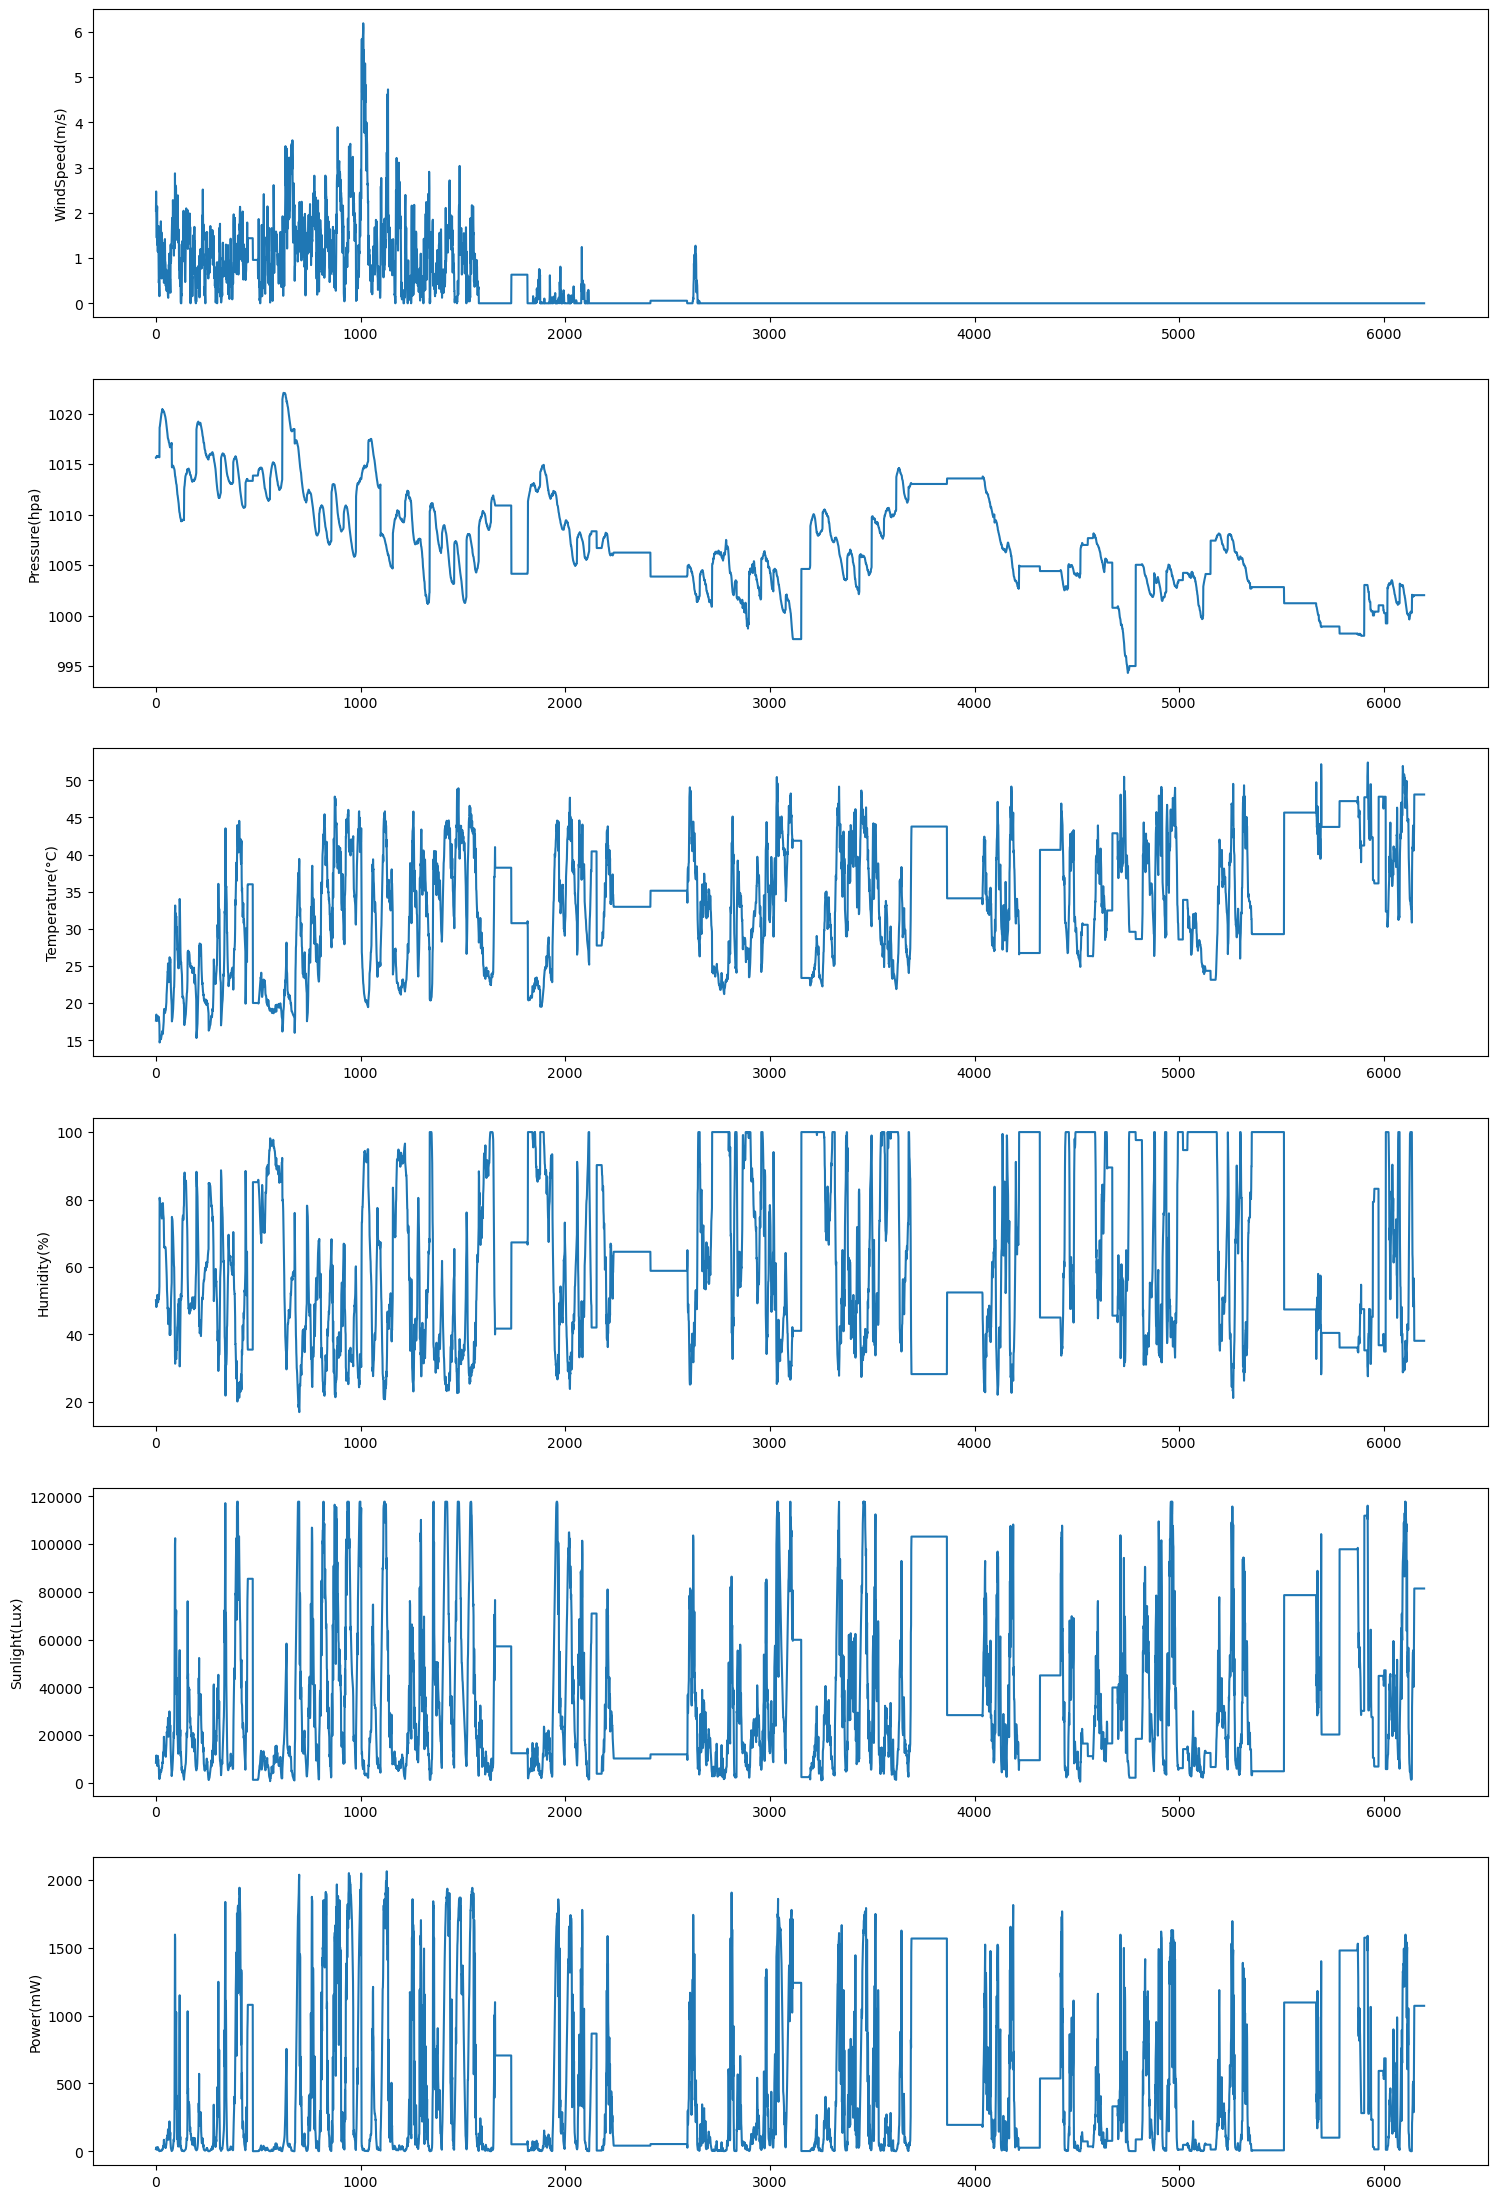

In [ ]:
fig, ax = plt.subplots(6, 1, figsize=(18, 28))
i = 0
train_imputed['idx'] = np.arange(0, len(train_imputed))

for col in features:
    ax[i].plot(
        train_imputed[train_imputed["is_missing"] == 1, 'idx'], 
        train_imputed[train_imputed["is_missing"] == 1, col],
        color='red',
        label=""
        )
    # moving_avg = train_imputed[col].rolling(6, center=True, min_periods=1).mean()
    # ax[i].plot(train_imputed['index'], moving_avg)
    ax[i].set_ylabel(col)
    i += 1